<center>
# Прогнозирование геологических характеристик нефтеносных пластов

<center>
## Цель

В данной задаче Вам предлагается, используя различные методы картопостроения (начиная от простых интерполяционных алгоритмов и заканчивая сложными моделями машинного обучения), предсказать значения параметра **песчанистости** в точках между скважинами.

**Целевой метрикой является - корень среднеквадратичной ошибки (RMSE)**.

<center>
## Описание кейса
В реальной жизни для изучения свойств целевого пласта на месторождении бурятся скважины, после чего в них опускаются специальные устройства - каротажные зонды. С их помощью проводится запись различных геофизических полей (например, радиоактивность или плотность), создаваемых горными породами. Подобные исследования называются геофизическими исследования скважин - ГИС. На основе полученных данных специалисты петрофизики проводят интерпретацию и сообщают информацию о том, на какой глубине находится пласт-коллектор, который может накапливать и отдавать флюиды. Типичный пример различных каротажных кривых и их совместной интерпретации представлен на рисунке.
<img src="img\log_interpretation.png">
На основе полученной интерпретации можно посчитать такое свойство как песчанистость в зоне бурения скважины. Песчанистость - это отношение толщин пластов-коллекторов к общей толщине геологического образования, данная характеристика позволяет геологам делать предположения об экономической эффективности работы с этим месторождением.
К сожалению, бурение скважин является очень дорогостоящей операцией, поэтому мы используем различные алгоритмы картопостроения с целью прогноза свойств в межскважинном пространстве.

В качестве данных в представленной задаче используется информация из синтетической модели месторождения, которая была построена на основе геологического обнажения Шестаково, Кемеровская область. По его описанию были определены различные геологические паараметры (размеры и геометрия тел, их связанность и значение песчанистости), которые в дальнейшем использовались при построение 3D модели. Подобный подход позволил достаточно точно отобразить реальную геологию и использовать полученный результат в качестве полигона для опробования и оценки различных подходов.
<img src="img\Razrez.png" width = 800>

Полученная в результате работ модель представляет из себя 3D грид, в котором каждой координате соответствует полигон 200х200 метров с некоторым количеством ячеек по глубине. Каждая ячейка характеризуется дисретным значением - песчанник (коллектор) или глина (неколлектор). Таким образом **для каждой координаты мы имеем значение песчанистоти**. Эти данные будут использоваться как **ground truth** для проверки качества решения.
<img src="img\3D_model.png" width = 800>

В предоставленном наборе данных имеется информация о 10% скважинных данных (в реальной жизни их может быть менее 1% от площади месторождения!), используя которые, Вам предлагается построить алгоритм, который бы предсказывал значения песчанистости в точках с отсутствующими значениями.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from scipy.spatial import cKDTree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
%matplotlib inline

In [14]:
#load data
data = pd.read_csv(r'data/Training_wells.csv')

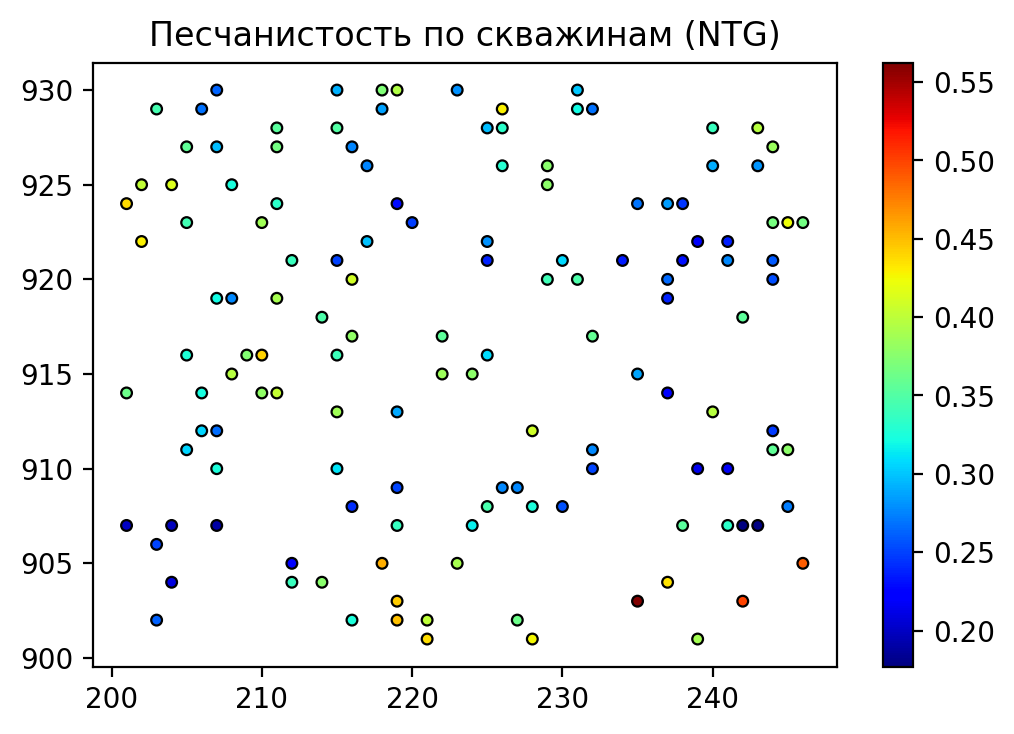

In [15]:
# Отрисуем имеющиеся данные
plt.figure(dpi = 200)
plt.title('Песчанистость по скважинам (NTG)')
plt.scatter(data.X, data.Y, cmap = 'jet', c = data.NTG, marker='o', lw = 0.8, edgecolors='black', s = 15)
plt.colorbar()
plt.show()

<center>
## Построение признакового пространства

В представленном решении в качестве признаков используются три ближайших к целевой точке значения и расстояния до них. Таким образом для каждой точки рассчитываются 6 признаков, которые в дальнейшем используются при прогнозировании. На рисунке ниже продемонстрирован пример такого построения признакового пространства.
<img src="img\neighbors.png">

In [16]:
# Создадим признаковое пространство по имеющимся данным
# Для кажой имеющейся скважины мы можем определить расстояние до ближайших точек и песчанистость в них
# Эта информация будет использоваться в качестве признаков, на основе которых будет строиться предсказание
feature_set = np.empty([0, 7])
for well in data.Well.unique():
    target_point = list(map(int, well.split('-')))
    well_distance,index = cKDTree(data[['X', 'Y']]).query(target_point, k = 4)
    train = np.hstack([well_distance[1:],
                       data.loc[index[1:], 'NTG'].values,
                       data.loc[data.Well==well, 'NTG'].values])
    feature_set = np.vstack([feature_set, train])

In [17]:
# Разобьем выборку на тренировочную и отложенную части
Feature_data = feature_set[:, :6]
Target_data = feature_set[:, 6]
X_train, X_test, y_train, y_test = train_test_split(Feature_data,
                                                    Target_data, random_state = 17, test_size = 0.2)

In [18]:
# Создадим и обучим модель с последующим прогнозом отложенной части
clf = Ridge(alpha=0.2, random_state = 17)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

In [19]:
# Посчитаем метрики результата
print('RMSE ошибка равна',np.sqrt(mean_squared_error(y_test, prediction)).round(4))

RMSE ошибка равна 0.0566


In [20]:
# Обучим модель на всем пуле имеющихся данных
clf.fit(Feature_data, Target_data)

Ridge(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [21]:
# Проведем предсказание для пустых точек
empty = pd.read_csv('data/Empty_part.csv')

feature_set_test = np.empty([0, 6])
for well in empty.Well.unique():
    target_point = list(map(int, well.split('-')))
    well_distance,index = cKDTree(data[['X', 'Y']]).query(target_point, k = 4)
    train = np.hstack([well_distance[1:],
                      data.loc[index[1:], 'NTG'].values])
    feature_set_test = np.vstack([feature_set_test, train])

In [22]:
# Предскажем значения для пустых точек и объединим с имеющимися для дальнейшей отрисовки
empty['NTG'] = clf.predict(feature_set_test)
resulting_pd = empty.append(data)

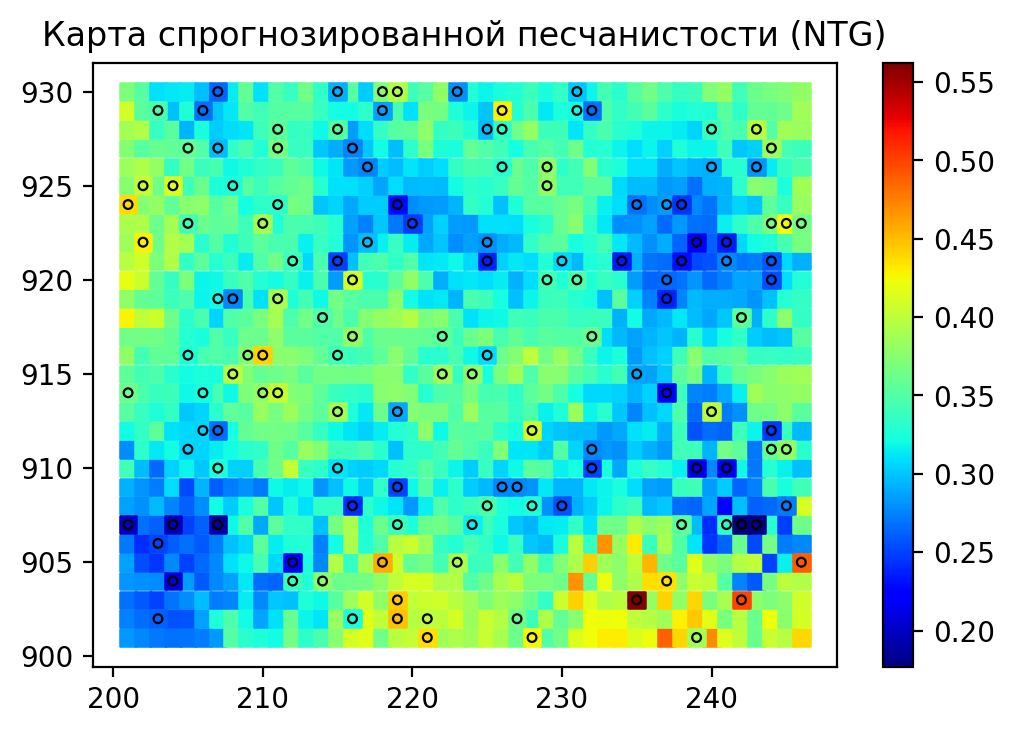

In [23]:
# Отрисуем полученную после прогноза карту
plt.figure(dpi = 200)
plt.title('Карта спрогнозированной песчанистости (NTG)')
plt.scatter(resulting_pd.X, resulting_pd.Y, cmap = 'jet', c = resulting_pd.NTG, marker='s', lw = 0.92)
plt.colorbar()
plt.scatter(data.X, data.Y, cmap = 'jet', c = data.NTG, marker='o', lw = 0.8, edgecolors='black', s = 10)
plt.show()

In [24]:
# Выгрузим данные для последующей оценки, предварительно введя название своей команды
team_name = 'RidgeMean'
empty.to_csv('%s_prediction.csv'%team_name, index = None)